### Importing required libraries

In [18]:
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import tensorflow as tf
from tensorflow import keras
### Use GPU if available
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

### Reading JSON file

In [2]:
with open("MFCC.json", 'r') as fp:
    mfcc = json.load(fp)

### Preparing data for DL

In [3]:
X = np.array(mfcc['mfcc'])
target = np.array(mfcc['type'])

In [4]:
normal = []
y = []

mapping = {
    'normal' : 0,
    'murmur' : 1,
    'artifact' : 2,
    'extrastole' : 3,
    'extrahls' : 4
}

for i in range(len(target)):
    y.append(mapping[target[i]])
    if target[i] == 'normal':
        normal.append(1)
    else:
        normal.append(0)

y = np.array(y)
normal = np.array(normal)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, normal, test_size= 0.2, stratify= normal)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size= 0.2, stratify= y_train)

### Building the model

In [6]:
model = keras.Sequential()

model.add(keras.layers.LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(100, return_sequences=True)))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(100, return_sequences=True)))
model.add(keras.layers.LSTM(100))

model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.3))

model.add(keras.layers.Dense(1, activation='sigmoid'))

In [7]:
optimizer = keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 130, 100)          52400     
_________________________________________________________________
bidirectional (Bidirectional (None, 130, 200)          160800    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 130, 200)          240800    
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               120400    
_________________________________________________________________
dense (Dense)                (None, 64)                6464      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

In [8]:
history = model.fit(X_train, y_train, validation_data=(X_validate, y_validate), batch_size=32, epochs=20)

Epoch 1/20
21/21 [==============================] - 2s 93ms/step - loss: 0.6728 - accuracy: 0.6021 - val_loss: 0.6259 - val_accuracy: 0.6786
Epoch 2/20
21/21 [==============================] - 1s 45ms/step - loss: 0.6349 - accuracy: 0.6587 - val_loss: 0.5896 - val_accuracy: 0.7143
Epoch 3/20
21/21 [==============================] - 1s 44ms/step - loss: 0.5966 - accuracy: 0.7079 - val_loss: 0.5527 - val_accuracy: 0.7560
Epoch 4/20
21/21 [==============================] - 1s 42ms/step - loss: 0.5780 - accuracy: 0.7168 - val_loss: 0.5519 - val_accuracy: 0.7440
Epoch 5/20
21/21 [==============================] - 1s 42ms/step - loss: 0.5826 - accuracy: 0.7198 - val_loss: 0.5493 - val_accuracy: 0.7440
Epoch 6/20
21/21 [==============================] - 1s 43ms/step - loss: 0.5720 - accuracy: 0.7228 - val_loss: 0.5861 - val_accuracy: 0.7024
Epoch 7/20
21/21 [==============================] - 1s 44ms/step - loss: 0.5593 - accuracy: 0.7303 - val_loss: 0.5349 - val_accuracy: 0.7500
Epoch 8/20
21

In [9]:
def plot_history(history):

    fig, axs = plt.subplots(2)

    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label='train accuracy')
    axs[0].plot(history.history['val_accuracy'], label='test accuracy')
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy Evaluation")

    # create error subplot
    axs[1].plot(history.history['loss'], label='train error')
    axs[1].plot(history.history['val_loss'], label='test error')
    axs[1].set_ylabel("Error")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error Evaluation")

    plt.show()

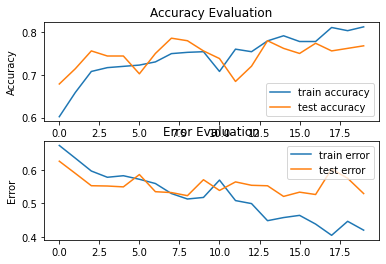

In [10]:
plot_history(history)

In [11]:
# evaluate the CNN on the test set
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print("Accuracy on test set is: {}".format(test_accuracy))
print("Error on test set is: {}".format(test_error))
print("\n\n")

# evaluate the CNN on the train set
test_error, test_accuracy = model.evaluate(X_train, y_train, verbose=2)
print("Accuracy on train set is: {}".format(test_accuracy))
print("Error on train set is: {}".format(test_error))
print("\n\n")

# evaluate the CNN on the validation set
test_error, test_accuracy = model.evaluate(X_validate, y_validate, verbose=2)
print("Accuracy on validation set is: {}".format(test_accuracy))
print("Error on validation set is: {}".format(test_error))

7/7 - 0s - loss: 0.4992 - accuracy: 0.7524
Accuracy on test set is: 0.7523809671401978
Error on test set is: 0.49921315908432007



21/21 - 0s - loss: 0.3556 - accuracy: 0.8286
Accuracy on train set is: 0.8286139965057373
Error on train set is: 0.35560357570648193



6/6 - 0s - loss: 0.5293 - accuracy: 0.7679
Accuracy on validation set is: 0.7678571343421936
Error on validation set is: 0.5293354392051697


<AxesSubplot:>

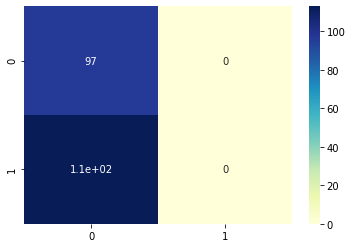

In [12]:
y_pred = np.argmax(model.predict(X_test),axis=1)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="YlGnBu")

### Building LSTM model for multi class classification

In [19]:
X = np.array(mfcc['mfcc'])
target = np.array(mfcc['type'])

y = []

mapping = {
    'normal' : 0,
    'murmur' : 1,
    'artifact' : 2,
    'extrastole' : 3,
    'extrahls' : 4
}

for i in range(len(target)):
    y.append(mapping[target[i]])
    

y = np.array(y)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, stratify= y)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size= 0.2, stratify= y_train)

In [21]:
obs = list(pd.DataFrame(y_train).value_counts().sort_index())
obs

[360, 169, 77, 41, 24]

In [22]:
weights = []
for i in range(0, 5):
    weights.append(sum(obs)/obs[i])

class_weight = {
    0 : weights[0],
    1 : weights[1],
    2 : weights[2],
    3 : weights[3],
    4 : weights[4]
}

In [23]:
class_weight

{0: 1.863888888888889,
 1: 3.970414201183432,
 2: 8.714285714285714,
 3: 16.365853658536587,
 4: 27.958333333333332}

In [24]:
model = keras.Sequential()

model.add(keras.layers.LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(100, return_sequences=True)))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(100, return_sequences=True)))
model.add(keras.layers.LSTM(100))

model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.3))

model.add(keras.layers.Dense(5, activation='softmax'))

In [25]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 130, 100)          52400     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 130, 200)          160800    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 130, 200)          240800    
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               120400    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                6464      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                

In [26]:
history = model.fit(X_train, y_train, validation_data=(X_validate, y_validate), batch_size=32, epochs=100, class_weight=class_weight)

Epoch 1/100
21/21 [==============================] - 2s 99ms/step - loss: 8.0230 - accuracy: 0.1446 - val_loss: 1.5786 - val_accuracy: 0.2440
Epoch 2/100
21/21 [==============================] - 1s 41ms/step - loss: 7.7632 - accuracy: 0.3949 - val_loss: 1.5586 - val_accuracy: 0.2321
Epoch 3/100
21/21 [==============================] - 1s 42ms/step - loss: 7.1780 - accuracy: 0.2802 - val_loss: 1.4031 - val_accuracy: 0.4286
Epoch 4/100
21/21 [==============================] - 1s 42ms/step - loss: 6.3362 - accuracy: 0.4650 - val_loss: 1.2792 - val_accuracy: 0.4702
Epoch 5/100
21/21 [==============================] - 1s 42ms/step - loss: 5.3862 - accuracy: 0.5112 - val_loss: 1.1194 - val_accuracy: 0.6250
Epoch 6/100
21/21 [==============================] - 1s 42ms/step - loss: 4.7248 - accuracy: 0.5604 - val_loss: 1.0898 - val_accuracy: 0.4583
Epoch 7/100
21/21 [==============================] - 1s 43ms/step - loss: 4.2870 - accuracy: 0.5469 - val_loss: 1.0119 - val_accuracy: 0.5655
Epoch 

21/21 [==============================] - 1s 44ms/step - loss: 1.8781 - accuracy: 0.7258 - val_loss: 0.8136 - val_accuracy: 0.6250
Epoch 59/100
21/21 [==============================] - 1s 42ms/step - loss: 2.1002 - accuracy: 0.7168 - val_loss: 0.9013 - val_accuracy: 0.6012
Epoch 60/100
21/21 [==============================] - 1s 42ms/step - loss: 1.8007 - accuracy: 0.7437 - val_loss: 0.9402 - val_accuracy: 0.5774
Epoch 61/100
21/21 [==============================] - 1s 43ms/step - loss: 1.7063 - accuracy: 0.7556 - val_loss: 0.9349 - val_accuracy: 0.5833
Epoch 62/100
21/21 [==============================] - 1s 42ms/step - loss: 1.7557 - accuracy: 0.7407 - val_loss: 0.8992 - val_accuracy: 0.6190
Epoch 63/100
21/21 [==============================] - 1s 46ms/step - loss: 2.0076 - accuracy: 0.7139 - val_loss: 1.0690 - val_accuracy: 0.5000
Epoch 64/100
21/21 [==============================] - 1s 44ms/step - loss: 1.8592 - accuracy: 0.7183 - val_loss: 0.9422 - val_accuracy: 0.5476
Epoch 65/100

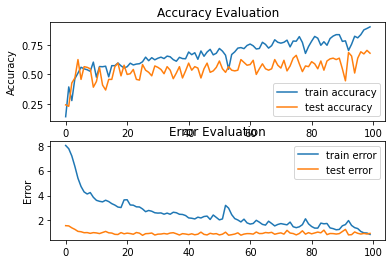

In [27]:
plot_history(history)

In [28]:
# evaluate the CNN on the test set
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print("Accuracy on test set is: {}".format(test_accuracy))
print("Error on test set is: {}".format(test_error))
print("\n\n")

# evaluate the CNN on the train set
test_error, test_accuracy = model.evaluate(X_train, y_train, verbose=2)
print("Accuracy on train set is: {}".format(test_accuracy))
print("Error on train set is: {}".format(test_error))
print("\n\n")

# evaluate the CNN on the validation set
test_error, test_accuracy = model.evaluate(X_validate, y_validate, verbose=2)
print("Accuracy on validation set is: {}".format(test_accuracy))
print("Error on validation set is: {}".format(test_error))

7/7 - 0s - loss: 1.0432 - accuracy: 0.6667
Accuracy on test set is: 0.6666666865348816
Error on test set is: 1.0431822538375854



21/21 - 0s - loss: 0.2576 - accuracy: 0.9165
Accuracy on train set is: 0.9165424704551697
Error on train set is: 0.25761526823043823



6/6 - 0s - loss: 0.9559 - accuracy: 0.6786
Accuracy on validation set is: 0.6785714030265808
Error on validation set is: 0.9558814764022827


<AxesSubplot:>

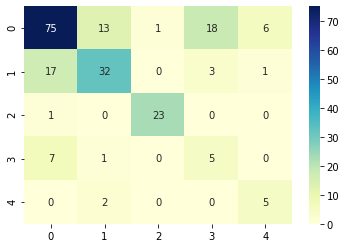

In [29]:
y_pred = np.argmax(model.predict(X_test),axis=1)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="YlGnBu")